In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
import pandas as pd
import numpy as np
import ipympl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from config_local import helpers

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline

hp = helpers()

In [2]:
_data_path = hp.get_data_path()
print(_data_path)

/media/jan/TOSHIBA EXT/SMHDD_22/data/


In [3]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv")
phenotypic_df.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,Fold,Partition
0,1000804,5,1.0,7.29,0.83,0,NaN,2,40,41,...,109,1,1.0,0.0,NaN,NaN,1.0,NaN,4.0,train
1,1023964,5,1.0,8.29,0.57,3,NaN,2,60,56,...,123,-999,1.0,0.0,NaN,NaN,1.0,1.0,3.0,train
2,1057962,5,1.0,8.78,-999.00,1,NaN,2,77,81,...,129,1,1.0,NaN,NaN,NaN,1.0,0.0,1.0,train
3,1099481,5,0.0,8.04,0.50,1,NaN,2,86,82,...,116,1,1.0,0.0,NaN,NaN,1.0,1.0,2.0,train
4,1127915,5,0.0,12.44,0.21,0,NaN,2,42,43,...,124,1,1.0,1.0,NaN,NaN,1.0,1.0,4.0,train


In [4]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv").fillna(-999)
dic = {}

for i, row in phenotypic_df.iterrows():
    
    id = str(row['ScanDir ID']).zfill(7)
    fold = int(row['Fold'])
    part = row['Partition']

    if fold != -999:
        file = _data_path + f"{part}/fold{fold}/wmean_mrda{id}_session_1_rest_1.nii.gz"
        img = nib.load(file)
        data = img.get_fdata()
        y = row['DX']
        y_bin = int(y>=1)
        dic[id] = {"img":img, "data":data, "dx":y, "dx_bin":y_bin, "part":part, "fold":fold, "data_reduced":data[3:-3, 3:-3 , :-6]}

In [5]:
orig_shape = dic["0010001"]["data"].shape

In [6]:
def train_loader(dic, i, pca=False):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if ((subj["part"]=="train") & (subj["fold"]!=i)):
            X_train.append(subj['data'].reshape(-1))
            y_train.append(subj['dx_bin'])
                
        if ((subj["part"]=="train") & (subj["fold"]==i)):
            X_val.append(subj['data'].reshape(-1))
            y_val.append(subj['dx_bin'])
            
    if pca:
        transformer = MiniBatchSparsePCA(n_components=10,
                                         batch_size=3,
                                         random_state=42)
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_val = transformer.transform(X_val)

    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [7]:
X_train, y_train, _, _ = train_loader(dic, 1)
eps=1e-3
f1_scores = []
coefs = []
lam = 0.74923

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = Lasso(alpha=lam,
                random_state=42,
                max_iter=7000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    f1_scores.append(score)
    coefs.append(clf.coef_)

mean_coefs = np.mean(coefs, axis=0)


In [8]:
f1_scores

[0.5436041083099906,
 0.6394957983193279,
 0.5576696240832864,
 0.5648395721925134,
 0.47058823529411764]

In [9]:
img_data = mean_coefs.reshape(orig_shape)

In [10]:
len(mean_coefs[mean_coefs!=0])

287

<AxesSubplot: ylabel='Count'>

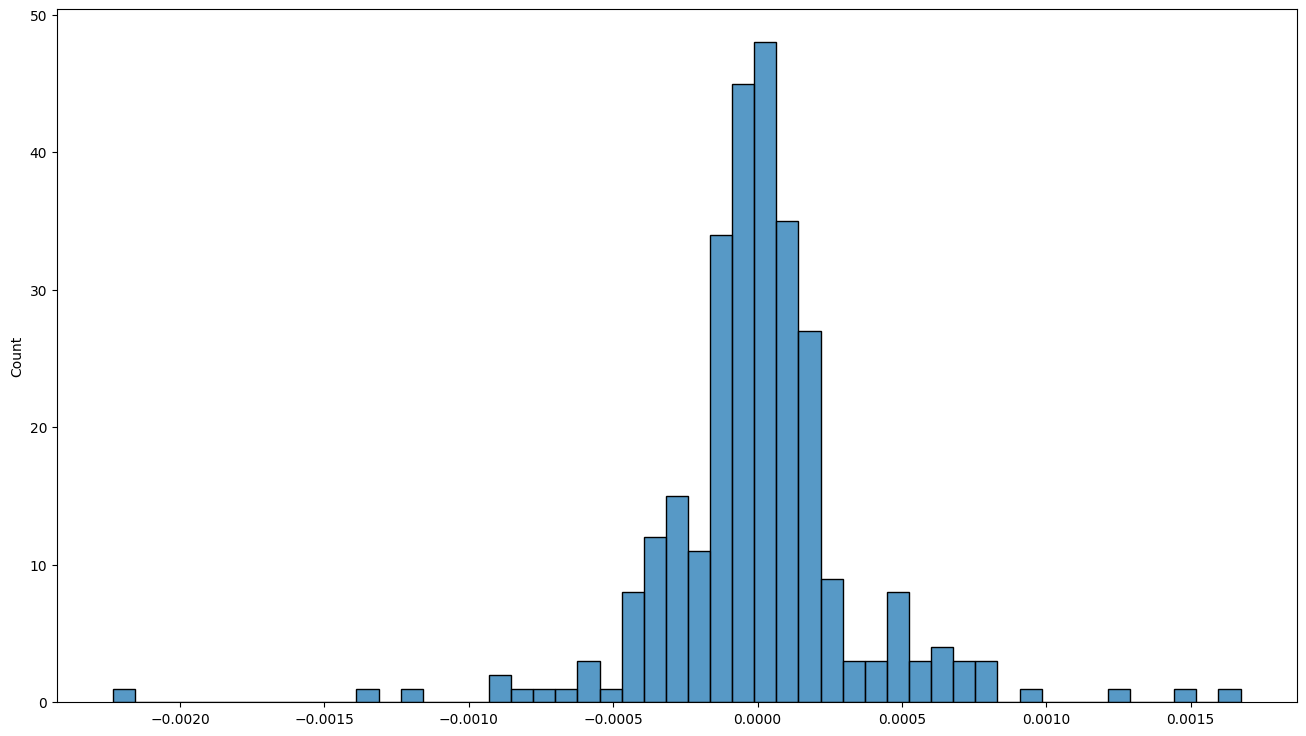

In [11]:
import seaborn as sns

fig , ax = plt.subplots(figsize=(16, 9))
sns.histplot(mean_coefs[mean_coefs!=0], ax=ax)

In [12]:
for i in range(img_data.shape[2]):
    num = sum(sum(img_data[:, :, i]!=0))
    if num >10 :
        print(f"Slice {i} has {num} non zero coefs.")

Slice 6 has 14 non zero coefs.
Slice 7 has 20 non zero coefs.
Slice 10 has 22 non zero coefs.
Slice 11 has 22 non zero coefs.
Slice 12 has 27 non zero coefs.
Slice 13 has 17 non zero coefs.
Slice 14 has 13 non zero coefs.
Slice 15 has 11 non zero coefs.
Slice 16 has 12 non zero coefs.


In [13]:
orig_shape

(49, 58, 47)

In [33]:

max(mean_coefs)

0.001672859807676058

In [42]:
from copy import copy

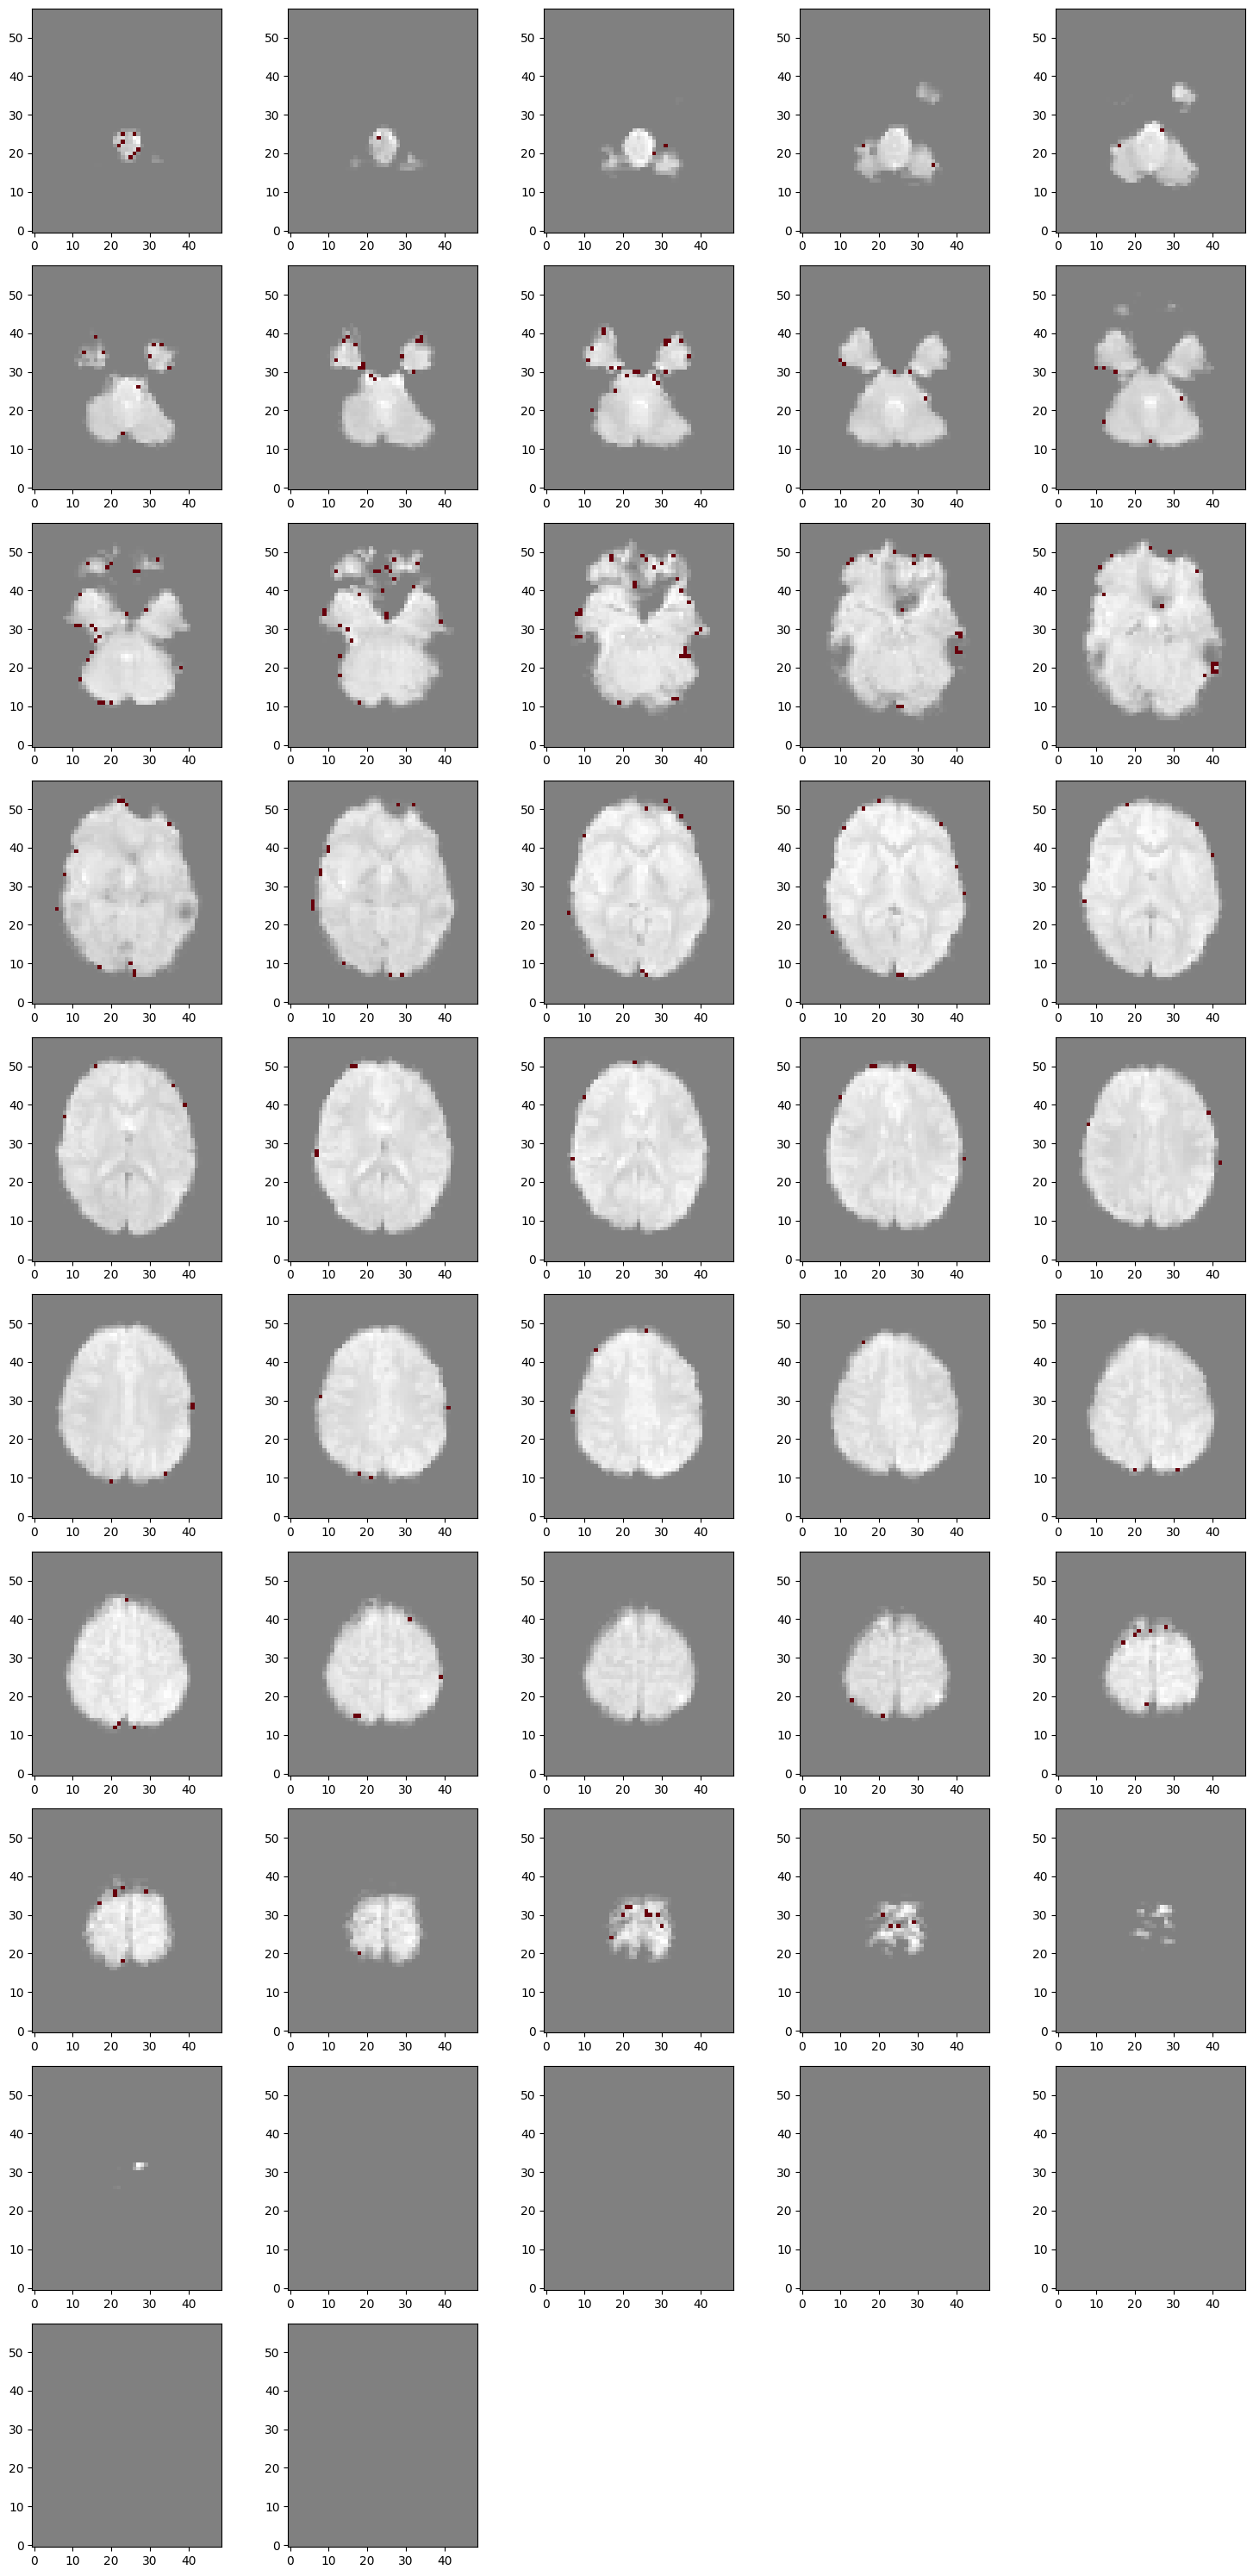

In [119]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
for i in range(img_data.shape[2]):
    
    coef_mask = 1.0*(img_data[:, :, i]!=0).T

    ax = plt.subplot(10, 5, i + 1)
    ax.imshow(dic["0010001"]["data"][:, :, i].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(coef_mask, origin='lower', cmap="Reds", alpha=coef_mask)
    # ax.set_xlabel('First dim voxel coords.', fontsize=12)
    # ax.set_ylabel('Second dim voxel coords', fontsize=12)
    # ax.set_title(f'Third dimension, slice nr. {i}', fontsize=15)
    # rect = patches.Rectangle((25, 25), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)

    ax.set_xlabel("")
plt.tight_layout()
plt.show()

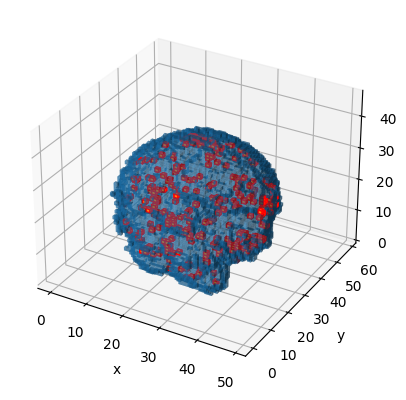

In [120]:
def make_ax(grid=False):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filled = np.array([
    [[1, 0, 1], [0, 0, 1], [0, 1, 0]],
    [[0, 1, 1], [1, 0, 0], [1, 0, 1]],
    [[1, 1, 0], [1, 1, 1], [0, 0, 0]]
])

ax = make_ax(True)
ax.voxels(dic["0010001"]["data"], alpha=0.5)
ax.voxels(img_data, edgecolors='red', shade=False)
plt.show()